# Imports

In [1]:
# Loading data
import os
import sys
# import math
# from pathlib import Path
# import json
import matplotlib.pyplot as plt

# image libraries
import numpy as np
from PIL import Image as Img
import cv2

# torch
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# utilities
import pdb
from IPython import embed
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

# Data loading

In [2]:
from dataloading import *

# Model

In [3]:
from model import *

# Ray marching

In [4]:
from rays import *

In [5]:
from visualize import visualize

In [6]:
from render import *

# Forward pass

In [7]:
# Training



def validation(dataloader_val, device, mlp, num_samples, L_xyz, L_directions, use_tensorf):
    mlp.eval()
    with torch.no_grad():
        # Forward pass thru validation set
        renders_all = []
        losses = []
        for iteration, (rays, pixels) in enumerate(tqdm(dataloader_val, ascii=True)):
            rays = rays.to(device)
            pixels = pixels.to(device)
#             with amp.autocast(enabled=False):
            renders = forward_pass(rays, pixels, mlp, device, num_samples, t_near, t_far, L_xyz, L_directions, white_bkgd, use_tensorf) 
            renders_all.append(renders)
            losses.append(F.mse_loss(renders, pixels))
        val_loss = sum(losses)/len(losses)
        
        
#         # Process renders into image
#         renders_all = torch.cat(renders_all, dim=0)
#         renders_all = torch.reshape(renders_all, (-1,D,D,3))*255
#         renders_all = renders_all.cpu().numpy()
#         renders_all = renders_all.astype(np.uint8)
# #         writer.add_image(f"val_epoch{epoch}", np.transpose(renders_all,(0,3,1,2)), dataformats='NCHW')

#         # Calculate PSNR using cv2 format
#         PSNRs = []
#         for i,label_img in enumerate(label_imgs):
#             # Convert PIL images to cv2 color mode
#             render_img = cv2.cvtColor(renders_all[i], cv2.COLOR_RGB2BGR) # numpy RGB --> cv2 BGR
#             label_img = cv2.cvtColor(np.asarray(label_img), cv2.COLOR_RGB2BGR) # PIL RGB --> numpy --> cv2 BGR
#             # psnr score
#             psnr = cv2.PSNR(render_img, label_img)
#             PSNRs.append(psnr)
#             print(f"psnr = {psnr}")
#         val_psnr = sum(PSNRs)/len(PSNRs)
        val_psnr = None
    return val_loss, val_psnr

# Training loop

In [8]:
%matplotlib inline
def main(num_epochs, batch_size, D, num_samples, L_xyz, L_directions, t_near, t_far, white_bkgd, debug, use_tensorf):
    # Preprocessing
    train_imgs, train_poses, train_fov = load_data("lego", "train", D, debug, indices=list(range(0,100)))
#     display(train_imgs[0])
#     val_imgs, val_poses, val_fov = load_data("lego", "val", D, debug)
    train_rays, train_pixels = data_to_rays(train_imgs, train_poses, train_fov, D)
#     val_rays, val_pixels = data_to_rays(val_imgs, val_poses, val_fov, D)
    # Dataloader
    train_dataset = NerfDataset(train_rays, train_pixels)
#     val_dataset = NerfDataset(val_rays, val_pixels)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
#     eval_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
#     val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
    
#     _ = visualize(show_list=["cameras", "points"],
#                   transforms=train_poses, dataset=train_dataset,
#                   t_near=t_near, t_far=t_far, num_samples=32)
#     return None, None

# """
    # Training objects
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if use_tensorf:
        print("Using tensorf model.")
        mlp = Tensorf(channels=128, R_s=96, R_c=288, bbox=[(-1.5,1.5),(-1.5,1.5),(-1.5,1.5)], w=1e-5).to(device)
#         mlp = Tensorf(channels=128, R_s=12, R_c=36, bbox=[(-4.0,4.0),(-4.0,4.0),(-4.0,4.0)]).to(device)
        optimizer = optim.Adam(
            [
                {'params':mlp.sigma, 'lr':0.02},
                {'params':mlp.feature, 'lr':0.02},
                {'params':mlp.B, 'lr':0.02},
                {'params':mlp.S.parameters(), 'lr':0.001},
            ],
            lr=1e-3
        )
        print(f"{mlp.R_s=}    {mlp.R_c=}     {mlp.N_final=}")
    else:
        print("Using vanilla Nerf model.")
        mlp = Nerf(L_xyz, L_directions).to(device)
        optimizer = optim.Adam(mlp.parameters(), lr=5e-4)
#     scaler = amp.GradScaler()
    mlp.train()

    
    # Training loop
    percents = [2000, 3000, 4000, 5500, 7000]
    percents = [s * 1.0/15000 for s in percents]
#     percents = [0.05, 0.1, 0.15, 0.2]
    steps = 0
    total_steps = num_epochs * len(train_dataloader)
    upsample_steps = [int(total_steps * p) for p in percents]
    print(f"{total_steps=}")
    print(f"{upsample_steps=}")
    scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer, gamma=0.1**(1/total_steps), last_epoch=-1
    )
    
    losses = []
    breakout = False
    for epoch in range(0,num_epochs):

        print(f"lr at epoch #{epoch} is {scheduler.get_lr()}")
        # Training loop, one epoch
        mlp.train()
#         losses = []
        for iteration, (rays, pixels) in enumerate(tqdm(train_dataloader, ascii=True)):
            if steps in upsample_steps:
                optimizer, scheduler = mlp.upsample(steps, upsample_steps[-1], total_steps, num_epochs, epoch)
                mlp = mlp.to(device)

                
            pixels = pixels.float()
            rays = rays.to(device, non_blocking=True)
            pixels = pixels.to(device, non_blocking=True)
#             with amp.autocast(enabled=False):
            renders, valid = forward_pass(rays, pixels, mlp, device, num_samples, t_near, t_far,
                                          L_xyz, L_directions, white_bkgd, use_tensorf,
                                          pause=True if (steps>500 and steps%100==0) else False)
            loss = F.mse_loss(renders, pixels[valid])
            if use_tensorf:
                loss = loss + mlp.L1_penalty()
            # Backprop
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            losses.append(loss.item())
            scheduler.step()
            steps += 1
#             if steps%100==0:
#                 print(losses[-1])
            if steps%1000==0:
                print(losses[-3:])
                plt.plot(list(range(len(losses))), losses)
                plt.yscale('log')
                plt.show()
                time.sleep(0.1)
        
                torch.save(mlp, f"./tensorf_D{D}_step{steps}of{total_steps}.pth")
                print(scheduler.get_lr())
    torch.save(mlp, f"./tensorf_D{D}_step{steps}of{total_steps}.pth")
#         if epoch%5==0:
#             render_img = render(mlp, eval_dataloader, num_samples, L_xyz, L_directions, white_bkgd, D, use_tensorf)


#         writer.add_scalar("loss/train", train_loss, epoch)

#         # Validation
#         if epoch%5==0:
#             # Rendering on validation images
#             val_loss, val_psnr = validation(val_dataloader, device, mlp, num_samples, L_xyz, L_directions, use_tensorf)
#             print(f"val #{epoch} loss = {val_loss}")
#             # Save checkpoint
#             checkpoint = {
#                 'model': mlp,
#                 'optimizer': optimizer,
#                 'scheduler': scheduler,
#                 'scaler': scaler,
#                 'logdir': logdir,
#                 'epoch': epoch,
#                 'val_loss': val_loss,
#                 'val_psnr': val_psnr
#             }
#             torch.save(checkpoint, f"{checkpointdir}{epoch}.pth")
#             print(f"Saved checkpoint for epoch #{epoch}.")
#             print()
#     writer.close()

# """  
    
    return mlp, losses

Converting camera poses to world frame rays...


100%|##########| 100/100 [00:11<00:00,  8.42it/s]


(16000000, 6)
(16000000, 3)
Using tensorf model.


/opt/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:448: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


mlp.R_s=96    mlp.R_c=288     mlp.N_final=500
total_steps=7814
upsample_steps=[1041, 1562, 2083, 2865, 3646]
lr at epoch #0 is [0.02, 0.02, 0.02, 0.001]


  0%|          | 0/3907 [00:00<?, ?it/s]/home/mhsiu/nerf/rays.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.cat((torch.tensor(t_near, device=device)[:,None],
/home/mhsiu/nerf/rays.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_far, device=device)[:,None]),
 26%|##5       | 999/3907 [03:51<11:44,  4.13it/s]

[0.007951652631163597, 0.008518480695784092, 0.008599787019193172]


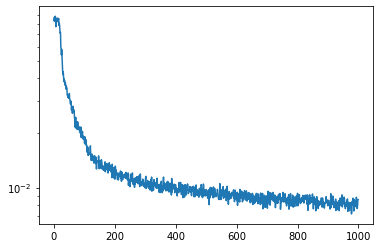

 26%|##5       | 1000/3907 [03:51<15:23,  3.15it/s]

[0.014891093533592076, 0.014891093533592076, 0.014891093533592076, 0.0007445546766796026]


 27%|##6       | 1041/3907 [04:01<10:10,  4.70it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 27%|##6       | 1042/3907 [04:01<10:27,  4.57it/s]

Upsampled! Nc=188.


 40%|####      | 1563/3907 [05:58<09:28,  4.12it/s]

Upsampled! Nc=229.


 51%|#####1    | 1999/3907 [07:34<07:08,  4.46it/s]

[0.007464180700480938, 0.007405568845570087, 0.007203768473118544]


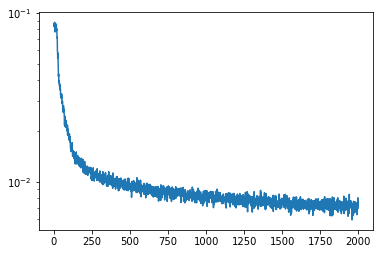

 51%|#####1    | 2000/3907 [07:35<09:30,  3.34it/s]

[0.011090500935606172, 0.011090500935606172, 0.011090500935606172, 0.0005545250467803074]


 53%|#####3    | 2083/3907 [07:54<07:32,  4.03it/s]

Upsampled! Nc=278.


 73%|#######3  | 2866/3907 [10:46<03:50,  4.51it/s]

Upsampled! Nc=373.


 77%|#######6  | 2999/3907 [11:14<03:00,  5.03it/s]

[0.006309799384325743, 0.006814939435571432, 0.006390357855707407]


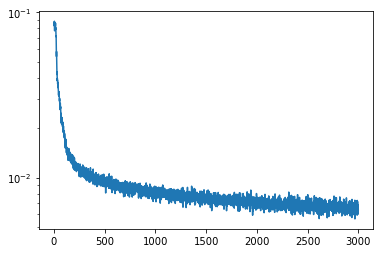

 77%|#######6  | 3000/3907 [11:14<04:37,  3.27it/s]

[0.008259917965407537, 0.008259917965407537, 0.008259917965407537, 0.0004129958982703765]


 93%|#########3| 3647/3907 [13:35<00:58,  4.45it/s]

Upsampled! Nc=499.


100%|##########| 3907/3907 [14:28<00:00,  4.50it/s]


lr at epoch #1 is [0.006322691910895634, 0.006322691910895634, 0.006322691910895634, 0.00031613459554478214]


  2%|2         | 92/3907 [00:20<11:10,  5.69it/s] 

[0.005754329264163971, 0.005731015000492334, 0.005692155100405216]


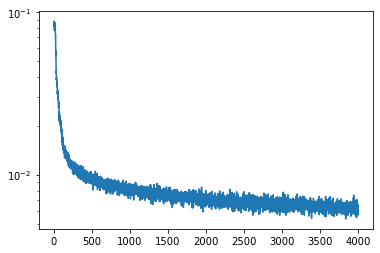

  2%|2         | 93/3907 [00:20<17:12,  3.69it/s]

[0.006151773052578816, 0.006151773052578816, 0.006151773052578816, 0.00030758865262894077]


 28%|##7       | 1092/3907 [03:50<08:05,  5.80it/s]

[0.006187337916344404, 0.005939291324466467, 0.00556429335847497]


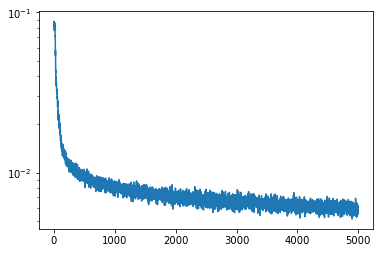

 28%|##7       | 1093/3907 [03:51<14:20,  3.27it/s]

[0.004581681301064552, 0.004581681301064552, 0.004581681301064552, 0.00022908406505322792]


 54%|#####3    | 2092/3907 [07:22<05:16,  5.74it/s]

[0.005745125003159046, 0.005602178163826466, 0.005209828726947308]


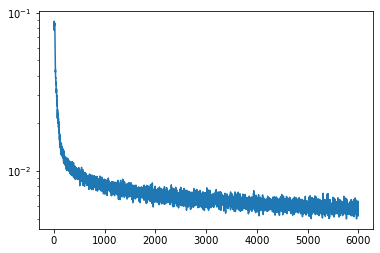

 54%|#####3    | 2093/3907 [07:23<08:11,  3.69it/s]

[0.003412317613980384, 0.003412317613980384, 0.003412317613980384, 0.0001706158806990194]


 79%|#######9  | 3092/3907 [10:54<02:58,  4.57it/s]

[0.0062065329402685165, 0.005614793859422207, 0.005934218876063824]


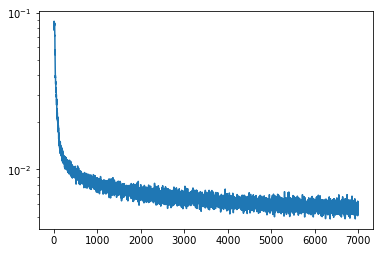

 79%|#######9  | 3093/3907 [10:54<04:29,  3.02it/s]

[0.002541405814493321, 0.002541405814493321, 0.002541405814493321, 0.00012707029072466595]


100%|##########| 3907/3907 [13:46<00:00,  4.73it/s]


In [9]:
import time

# if __name__=='__main__':
# Set training hyperparameters
t_near = 2
t_far = 6
white_bkgd = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Resolution and rays
D = 400
num_samples = 64
batch_size = 4096
# Embedding
L_xyz = 10
L_directions = 4
# Training schedule
num_epochs = 2
debug = False
use_tensorf = True

torch.cuda.empty_cache()
mlp, losses = main(num_epochs, batch_size, D, num_samples, L_xyz, L_directions, t_near, t_far, white_bkgd, debug, use_tensorf)

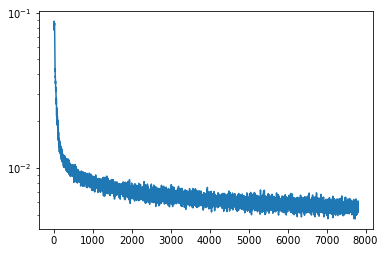

[0.005406888201832771, 0.005688476841896772, 0.005449745338410139, 0.006039024796336889, 0.005202730651944876]


In [12]:
%matplotlib inline
plt.plot(list(range(len(losses))), losses)
plt.yscale('log')
plt.show()
time.sleep(0.1)
print(losses[-5:])

Converting camera poses to world frame rays...


100%|##########| 2/2 [00:00<00:00, 62.68it/s]


(320000, 6)
(320000, 3)


100%|##########| 79/79 [00:05<00:00, 14.28it/s]


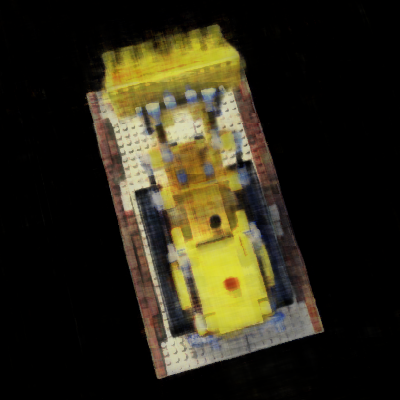

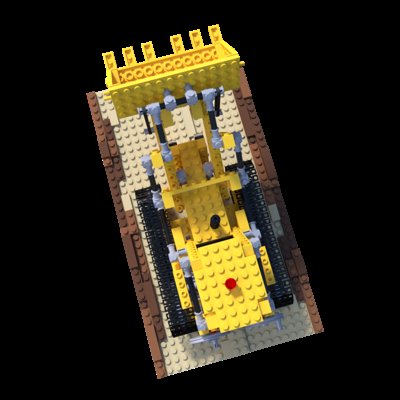

psnr_=22.42633374766488   psnr=22.426333747664884


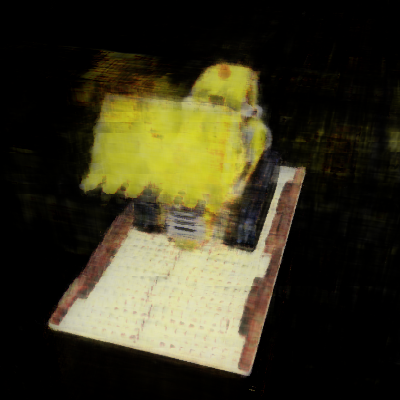

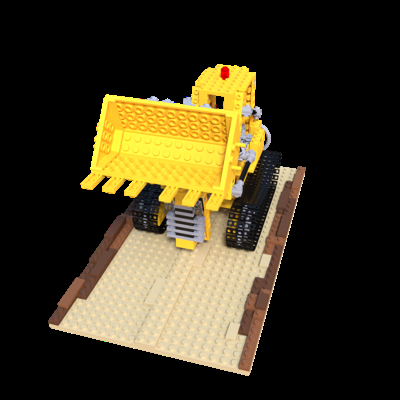

psnr_=20.477482523429003   psnr=20.477482523429007


[(<PIL.Image.Image image mode=RGB size=400x400 at 0x7F1A7DF9BE20>,
  <PIL.Image.Image image mode=RGB size=400x400 at 0x7F1A7DFC9520>,
  22.426333747664884),
 (<PIL.Image.Image image mode=RGB size=400x400 at 0x7F1A7DFEBDC0>,
  <PIL.Image.Image image mode=RGB size=400x400 at 0x7F1A7DFC9370>,
  20.477482523429007)]

In [21]:
mlp = torch.load("tensorf_D400_step7814of7814.pth")
# mlp.voxel
D=400
# Preprocessing
train_imgs, train_poses, train_fov = load_data("lego", "val", D, debug=False, indices=list(range(0,2)))
train_rays, train_pixels = data_to_rays(train_imgs, train_poses, train_fov, D)

# val_imgs, val_poses, val_fov = load_data("lego", "val", D, debug=True)
# val_rays, val_pixels = data_to_rays(val_imgs, val_poses, val_fov, D)

# Dataloader
train_dataset = NerfDataset(train_rays, train_pixels)
# val_dataset = NerfDataset(val_rays, val_pixels)
eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

render(mlp, eval_loader, int(num_samples/2), L_xyz, L_directions, white_bkgd, D, use_tensorf)

In [ ]:
# pdb.pm()

In [ ]:
# xx = torch.tensor(
#     [
#         [[0,10],[0,20]],
#         [[0,100],[0,200]],
# #         [[0,1000],[0,10000]]
#     ],
#     dtype=torch.float32
# )
# print(xx.shape)
# xx = F.interpolate(xx, size=4, mode='linear')
# print(xx)
# print(xx.shape)